In [8]:
import torch
print("GPU Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

GPU Available: True
GPU Name: Tesla T4


In [9]:
IMG_DIR = "/content/drive/MyDrive/crowd_project_B/processed_images"
DENSITY_DIR = "/content/drive/MyDrive/crowd_project_B/density_maps"
BEST_MODEL_PATH = "/content/drive/MyDrive/crowd_project_B/best_csrnet_PB.pth"

In [21]:
import os, cv2
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt

transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])

class CrowdDataset(Dataset):
    def __init__(self, img_dir, den_dir, file_list):
        self.img_dir = img_dir
        self.den_dir = den_dir
        self.files = file_list

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        name = self.files[idx]

        # Load & transform image
        img = cv2.imread(os.path.join(self.img_dir, name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = transform(img)

        # Load density map
        den = np.load(os.path.join(self.den_dir, name.replace('.jpg', '.npy')))

        # Downsample density from 512→64 and PRESERVE COUNT
        h_map, w_map = den.shape[0] // 8, den.shape[1] // 8
        den = cv2.resize(den, (w_map, h_map), interpolation=cv2.INTER_CUBIC)
        den = den * 64   # (8×8 = 64)

        # Convert to tensor
        den = torch.tensor(den, dtype=torch.float32).unsqueeze(0)

        return img, den


In [11]:
files = [f for f in os.listdir(IMG_DIR) if f.endswith('.jpg')]
train_files, val_files = train_test_split(files, test_size=0.2, random_state=42)

train_loader = DataLoader(CrowdDataset(IMG_DIR, DENSITY_DIR, train_files),
                          batch_size=4, shuffle=True)
val_loader   = DataLoader(CrowdDataset(IMG_DIR, DENSITY_DIR, val_files),
                          batch_size=4, shuffle=False)

print("Train:", len(train_files), "Val:", len(val_files))

Train: 320 Val: 80


In [12]:
cfg = {'frontend':[64,64,'M',128,128,'M',256,256,256,'M',512,512,512],
       'backend':[512,512,512,256,128,64]}

def make_layers(cfg_list, in_channels=3, dilation=False):
    layers=[]
    for v in cfg_list:
        if v=='M':
            layers.append(nn.MaxPool2d(2,2))
        else:
            d = 2 if dilation else 1
            layers += [nn.Conv2d(in_channels, v, 3, padding=d, dilation=d),
                       nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

class CSRNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.frontend = make_layers(cfg['frontend'],3)
        self.backend = make_layers(cfg['backend'],512,dilation=True)
        self.output = nn.Conv2d(64,1,1)
    def forward(self,x):
        x=self.frontend(x)
        x=self.backend(x)
        x=self.output(x)
        return x


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CSRNet().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.95)

In [14]:
num_epochs = 100
best_val_loss = float('inf')

train_losses = []
val_losses   = []
train_mae    = []
val_mae      = []

for epoch in range(num_epochs):
    model.train()
    t_loss = t_mae = 0

    for imgs, dens in train_loader:
        imgs, dens = imgs.to(device), dens.to(device)

        pred = model(imgs)
        loss = criterion(pred, dens)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        t_loss += loss.item()
        t_mae  += abs(pred.sum().item() - dens.sum().item())

    t_loss /= len(train_loader)
    t_mae  /= len(train_loader)
    train_losses.append(t_loss)
    train_mae.append(t_mae)

    model.eval()
    v_loss = v_mae = 0
    with torch.no_grad():
        for imgs, dens in val_loader:
            imgs, dens = imgs.to(device), dens.to(device)
            pred = model(imgs)
            v_loss += criterion(pred, dens).item()
            v_mae  += abs(pred.sum().item() - dens.sum().item())

    v_loss /= len(val_loader)
    v_mae  /= len(val_loader)
    val_losses.append(v_loss)
    val_mae.append(v_mae)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"TL:{t_loss:.4f} VL:{v_loss:.4f} "
          f"TMAE:{t_mae:.2f} VMAE:{v_mae:.2f}")

    if v_loss < best_val_loss:
        best_val_loss = v_loss
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print("Best Model Saved")

    scheduler.step()


Epoch [1/100] TL:0.0000 VL:0.0000 TMAE:61.14 VMAE:5.07
Best Model Saved
Epoch [2/100] TL:0.0000 VL:0.0000 TMAE:5.22 VMAE:4.32
Best Model Saved
Epoch [3/100] TL:0.0000 VL:0.0000 TMAE:4.32 VMAE:5.08
Best Model Saved
Epoch [4/100] TL:0.0000 VL:0.0000 TMAE:3.90 VMAE:2.21
Best Model Saved
Epoch [5/100] TL:0.0000 VL:0.0000 TMAE:3.41 VMAE:2.90
Best Model Saved
Epoch [6/100] TL:0.0000 VL:0.0000 TMAE:3.40 VMAE:3.03
Best Model Saved
Epoch [7/100] TL:0.0000 VL:0.0000 TMAE:3.11 VMAE:3.67
Best Model Saved
Epoch [8/100] TL:0.0000 VL:0.0000 TMAE:3.97 VMAE:3.32
Best Model Saved
Epoch [9/100] TL:0.0000 VL:0.0000 TMAE:3.01 VMAE:3.00
Best Model Saved
Epoch [10/100] TL:0.0000 VL:0.0000 TMAE:2.83 VMAE:2.01
Best Model Saved
Epoch [11/100] TL:0.0000 VL:0.0000 TMAE:2.83 VMAE:2.02
Best Model Saved
Epoch [12/100] TL:0.0000 VL:0.0000 TMAE:2.72 VMAE:1.98
Best Model Saved
Epoch [13/100] TL:0.0000 VL:0.0000 TMAE:3.11 VMAE:3.38
Epoch [14/100] TL:0.0000 VL:0.0000 TMAE:3.40 VMAE:2.63
Epoch [15/100] TL:0.0000 VL:0.0000

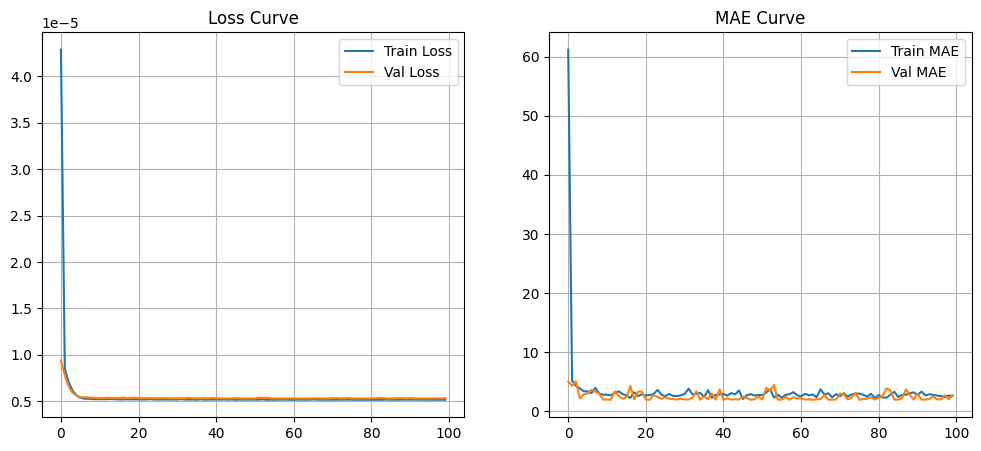

In [15]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve"); plt.legend(); plt.grid()

plt.subplot(1,2,2)
plt.plot(train_mae, label="Train MAE")
plt.plot(val_mae, label="Val MAE")
plt.title("MAE Curve"); plt.legend(); plt.grid()

plt.show()

In [16]:
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.eval()
print("Best Model Loaded!")

Best Model Loaded!


GT Count: 0.52
Pred Count: 1.99


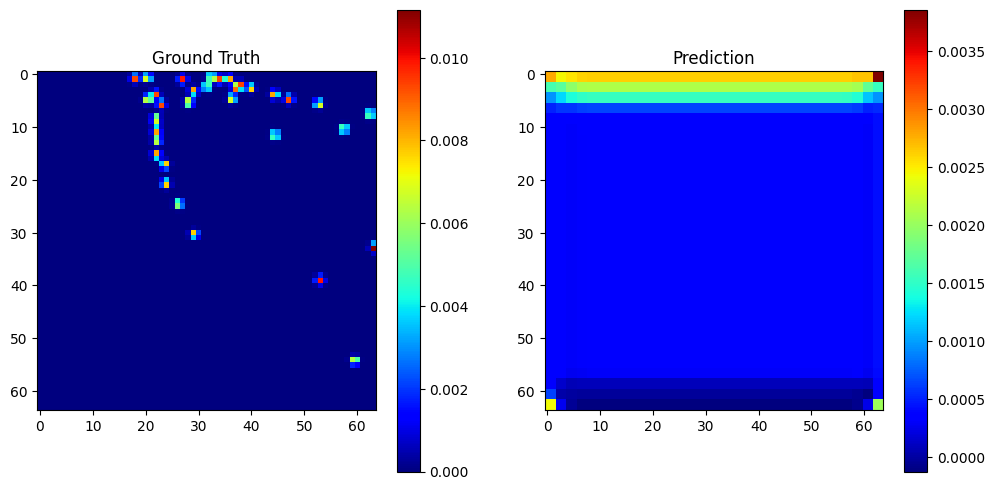

In [17]:
imgs, dens = next(iter(val_loader))
imgs, dens = imgs.to(device), dens.to(device)

with torch.no_grad():
    pred = model(imgs)

gt = dens[0].cpu().numpy().squeeze()
pd = pred[0].detach().cpu().numpy().squeeze()

print(f"GT Count: {gt.sum():.2f}")
print(f"Pred Count: {pd.sum():.2f}")

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(gt, cmap='jet'); plt.title("Ground Truth")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(pd, cmap='jet'); plt.title("Prediction")
plt.colorbar()
plt.show()

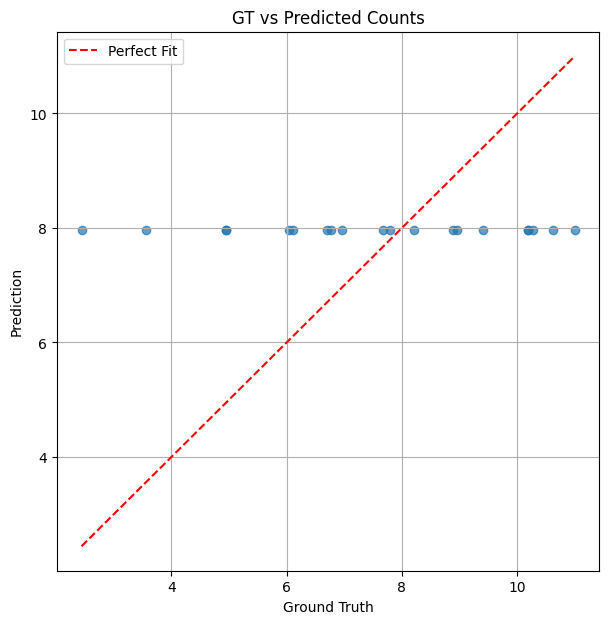

In [18]:
gt_counts = []
pred_counts = []

model.eval()
with torch.no_grad():
    for imgs, dens in val_loader:
        imgs, dens = imgs.to(device), dens.to(device)
        pred = model(imgs)

        gt_counts.append(dens.sum().item())
        pred_counts.append(pred.sum().item())

plt.figure(figsize=(7,7))
plt.scatter(gt_counts, pred_counts, alpha=0.7)
plt.plot([min(gt_counts), max(gt_counts)],
         [min(gt_counts), max(gt_counts)], 'r--', label="Perfect Fit")
plt.xlabel("Ground Truth"); plt.ylabel("Prediction")
plt.title("GT vs Predicted Counts")
plt.grid(); plt.legend()
plt.show()

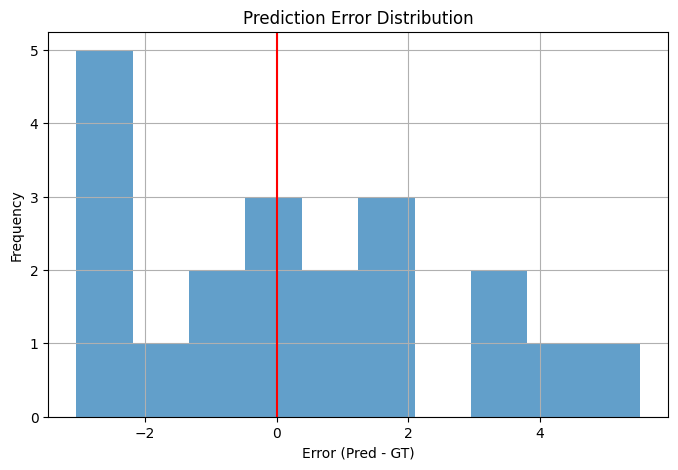

In [19]:
errors = np.array(pred_counts) - np.array(gt_counts)
plt.figure(figsize=(8,5))
plt.hist(errors, bins=10, alpha=0.7)
plt.axvline(0, color='red')
plt.title("Prediction Error Distribution")
plt.xlabel("Error (Pred - GT)")
plt.ylabel("Frequency")
plt.grid()
plt.show()

In [20]:
imgs, dens = next(iter(train_loader))
print("GT Human Count =", dens.sum().item())

GT Human Count = 7.2078118324279785
